Code adapted from Richard Bownes [Fine Tuning GPT-2 for Magic Flavour Text Generation](https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93)

In [1]:
!pip install transformers
!pip install bert-extractive-summarizer
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 51.1 MB/s 
     |████████████████████████████████| 6.6 MB 41.5 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
import pandas as pd
import numpy as np
import random
import os
import time
import datetime

import torch
CUDA_LAUNCH_BLOCKING="1"
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load dataset
nft_content = pd.read_csv("drive/My Drive/nft_content.csv")
nft_content.columns

Index(['articleUrl', 'date', 'title', 'authorName', 'clapCount', 'category',
       'length', 'content_clean', 'sentiment', 'content_raw'],
      dtype='object')

In [4]:
#keep only clean content in dataset
nft_content = nft_content['content_clean']

In [5]:
# instanciate tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# evaluate charge of work
max_content = max([len(tokenizer.encode(content)) for content in nft_content])
print(f'The longest marketing content is {max_content} tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1463 > 1024). Running this sequence through the model will result in indexing errors


The longest marketing content is 26906 tokens long.


In [7]:
# check GPU capacity
!nvidia-smi

Mon Jun 13 16:57:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# create dataloader for our corpus, limiting length to our capacity
class NFTdata(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_content):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=128, 
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [9]:
# Split into training and validation sets
dataset = NFTdata(nft_content, tokenizer, max_length=max_content)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 3186 samples for training, and 355 samples for validation testing'

In [10]:
# generate the dataloader
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = 32
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = 32 
        )

In [11]:
# model configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instanciate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run on the GPU.
device = torch.device("cuda")
model.cuda()

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [12]:
# training parameters
epochs = 4
warmup_steps = 1e2
sample_every = 100

In [13]:
# instantiate AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )
# deprecated, should use optimizer = torch.optim.AdamW

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [14]:
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps
                                            )

In [15]:
torch.cuda.empty_cache()
torch.manual_seed(42)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4
Average Training Loss: 11.365840835571289. Epoch time: 0:01:57
Validation loss: 5.115008274714152. Validation Time: 0:00:04
Beginning epoch 2 of 4
Average Training Loss: 4.843984436988831. Epoch time: 0:01:57
Validation loss: 4.589007457097371. Validation Time: 0:00:04
Beginning epoch 3 of 4
Average Training Loss: 4.44753824710846. Epoch time: 0:01:57
Validation loss: 4.452170809110005. Validation Time: 0:00:04
Beginning epoch 4 of 4
Average Training Loss: 4.275560100078582. Epoch time: 0:01:57
Validation loss: 4.419618447621663. Validation Time: 0:00:04
Total training took 0:08:04


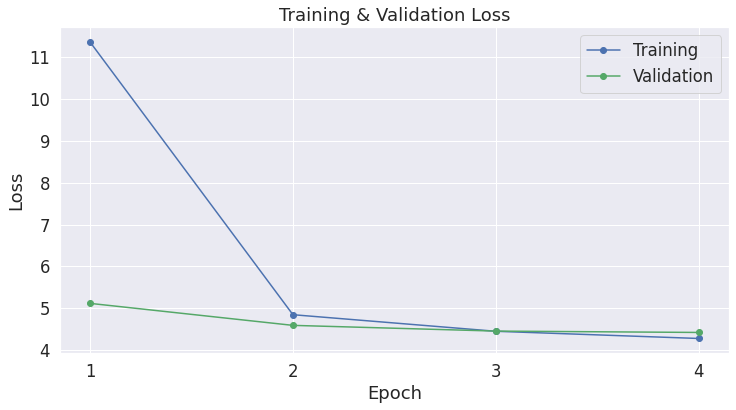

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [17]:
# save the model in gdrive
output_dir = '/content/drive/My Drive/opencampus/NFT_text_generation/model'

model_to_save = model#.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# save the training arguments with the trained model
torch.save(model_to_save, os.path.join(output_dir, 'NFT_text_generation.bin'))

In [18]:
# generate samples from the model 
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 256,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: new nft marketplace (top 50 nft projects  here!)
i am just excited announce new nft marketplace, i’m launching first-of-its-kind new nft marketplace nft marketplace. now marketplace offers top 50 artists.
about marketplace marketplace
here, firstly, you’ll  able participate marketplace:
as marketplace “anonymous art collectibles”,  receive limited edition nft (digital editions) collectibles  available via marketplace.  additionally,     able purchase sell nft arrks (tickets) or “nft art collectibles”.
what nft marketplace?
we’ve seen, first-of-its-kind marketplace, nft marketplace designed providing high-res gifting options artists, artists, creators collectors looking bring value collectibles.
marketplace includes:
a free nft marketplace (top 50“nft projects)
i’m launching nft marketplace first-of-its-kind, i’m just glad announce first-of-its-kind marketplace  nft marketplace.  sell first digital sale  nft arrk (tickets), nft art collectibles  nft arrk


1: how buy nft sale price
t

In [25]:
# use a text summarization model to generate tweet-length sentence from the model input
from summarizer import Summarizer
summarize=Summarizer()

for i, sample_output in enumerate(sample_outputs):
  summary = summarize(tokenizer.decode(sample_output, skip_special_tokens=True), max_length=15)
  print(i)
  print(len(summary))
  print(summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
0

1
0

2
0

